# Getting and preparing the data



To demonstrate the post processing algorithm we use the "COMPAS" dataset from [ProPublica](https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv). The labels represent the two-year recidivism ID, i.e. whether a person got rearrested within two years (label 1) or not (label 0). The features include sex, age, as well as information on prior incidents.

To start, let's download the dataset using `tempeh`

In [1]:
import pandas as pd
import numpy as np
from tempeh.configurations import datasets

compas_dataset = datasets['compas']()
X_train, X_test = compas_dataset.get_X(format=pd.DataFrame)
y_train, y_test = compas_dataset.get_y(format=pd.Series)
sensitive_features_train, sensitive_features_test = compas_dataset.get_sensitive_features('race', format=pd.Series)
X_train.loc[0], y_train[0]

(age                        25.000000
 juv_fel_count               0.000000
 juv_misd_count             -2.340451
 juv_other_count             1.000000
 priors_count              -15.010999
 age_cat_25 - 45             1.000000
 age_cat_Greater than 45     0.000000
 age_cat_Less than 25        0.000000
 c_charge_degree_F           0.000000
 c_charge_degree_M           1.000000
 Name: 0, dtype: float64, 1.0)

# Create a fairness-unaware model

First we set up a helper function that will help in analyzing the dataset as well as predictions from our models. Feel free to skip to the next cell for the actual logic.

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.cm as cm

# show_proportions is only a helper function for plotting
def show_proportions(X, sensitive_features, y_pred, y=None, description=None, plot_row_index=1):
    print("\n" + description)
    plt.figure(plot_row_index)
    plt.title(description)
    plt.ylabel("P[recidivism predicted | conditions]")
    
    indices = {}
    positive_indices = {}
    negative_indices = {}
    recidivism_count = {}
    recidivism_pct = {}
    groups = np.unique(sensitive_features.values)
    n_groups = len(groups)
    max_group_length = max([len(group) for group in groups])
    color = cm.rainbow(np.linspace(0,1,n_groups))
    x_tick_labels_basic = []
    x_tick_labels_by_label = []
    for index, group in enumerate(groups):
        indices[group] = sensitive_features.index[sensitive_features == group]
        recidivism_count[group] = sum(y_pred[indices[group]])
        recidivism_pct[group] = recidivism_count[group]/len(indices[group])
        print("P[recidivism predicted | {}]                {}= {}".format(group, " "*(max_group_length-len(group)), recidivism_pct[group]))
    
        plt.bar(index + 1, recidivism_pct[group], color=color[index])
        x_tick_labels_basic.append(group)
    
        if y is not None:
            positive_indices[group] = sensitive_features.index[(sensitive_features == group) & (y == 1)]
            negative_indices[group] = sensitive_features.index[(sensitive_features == group) & (y == 0)]
            prob_1 = sum(y_pred[positive_indices[group]])/len(positive_indices[group])
            prob_0 = sum(y_pred[negative_indices[group]])/len(negative_indices[group])
            print("P[recidivism predicted | {}, recidivism]    {}= {}".format(group, " "*(max_group_length-len(group)) , prob_1))
            print("P[recidivism predicted | {}, no recidivism] {}= {}".format(group, " "*(max_group_length-len(group)), prob_0))

            plt.bar(n_groups + 1 + 2 * index, prob_1, color=color[index])
            plt.bar(n_groups + 2 + 2 * index, prob_0, color=color[index])
            x_tick_labels_by_label.extend(["{} recidivism".format(group), "{} no recidivism".format(group)])
    
    x_tick_labels = x_tick_labels_basic + x_tick_labels_by_label
    plt.xticks(range(1, len(x_tick_labels)+1), x_tick_labels, rotation=45, horizontalalignment="right")

To get started we look at a very basic Logistic Regression model. We fit it to the training data and plot some characteristics of training and test data as well as the predictions of the model on those datasets.

We notice a stark contrast in the predictions with African-Americans being a lot more likely to be predicted to reoffend, similar to the original training data. However, there's even a disparity between the subgroup of African-Americans and Caucasians with recidivism. When considering only the samples labeled with "no recidivism" African-Americans are much more likely to be predicted to reoffend than Caucasians. The test data shows a similar disparity.


original test data:
P[recidivism predicted | African-American]                = 0.5457198443579766
P[recidivism predicted | Caucasian]                       = 0.3795518207282913

fairness-unaware prediction on test data:
P[recidivism predicted | African-American]                = 0.5155642023346303
P[recidivism predicted | African-American, recidivism]    = 0.661319073083779
P[recidivism predicted | African-American, no recidivism] = 0.3404710920770878
P[recidivism predicted | Caucasian]                       = 0.2857142857142857
P[recidivism predicted | Caucasian, recidivism]           = 0.42435424354243545
P[recidivism predicted | Caucasian, no recidivism]        = 0.20090293453724606


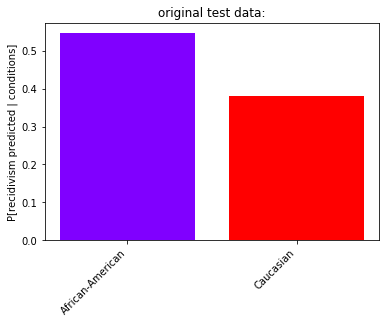

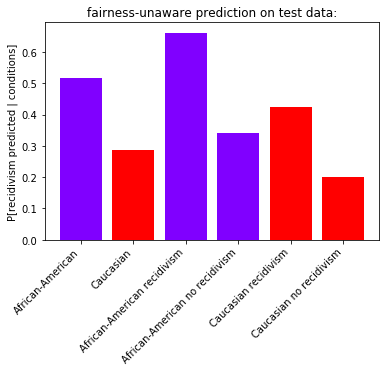

In [3]:
from sklearn.linear_model import LogisticRegression

unconstrained_predictor = LogisticRegression(solver='liblinear')
unconstrained_predictor.fit(X_train, y_train)
    
# print and plot data from training and test set as well as predictions with fairness-unaware classifier on both sets 
# show only test data related plots by default - uncomment the next two lines to see training data plots as well
# show_proportions(X_train, sensitive_features_train, y_train, description="original training data:", plot_row_index=1)
# show_proportions(X_train, sensitive_features_train, unconstrained_predictor.predict(X_train), y_train, description="fairness-unaware prediction on training data:", plot_row_index=2)
show_proportions(X_test, sensitive_features_test, y_test, description="original test data:", plot_row_index=3)
show_proportions(X_test, sensitive_features_test, unconstrained_predictor.predict(X_test), y_test, description="fairness-unaware prediction on test data:", plot_row_index=4)
plt.show()

# Postprocessing the model to get a fair model

The idea behind postprocessing is to alter the output of the fairness-unaware model to achieve fairness. The postprocessing algorithm requires three input arguments:
- the matrix of samples X
- the vector of predictions y from the fairness-unaware model 
- the vector of group attribute values A (in the code we refer to it as `sensitive_features`)

The goal is to make the output fair with respect to constraints. The postprocessing algorithm uses one of
- Demographic Parity (DP): $P\ [\ h(X)=\hat{y}\ |\ A=a] = P\ [\ h(X)=\hat{y}\ ] \qquad \forall a, \hat{y}$
- Equalized Odds (EO): $P\ [\ h(X)=\hat{y}\ |\ A=a, Y=y] = P\ [\ h(X)=\hat{y}\ |\ Y=y\ ] \qquad \forall a, \hat{y}$

where $h(X)$ is the prediction based on the input $X$, $\hat{y}$ and $y$ are labels, and $a$ is a sensitive feature value. In this example, we'd expect the postprocessed model with DP to be balanced between races. In this particular scenario it makes more sense to aim at fairness through accuracy like EO. EO does not make the same guarantees. Instead, it ensures parity between the subgroups of each race with label 1 in the training set, and parity between the subgroups of each race with label 0 in the training set. Applied to this scenario, this means that the subgroups of each race who reoffended in the past are equally likely to be predicted to reoffend (and therefore also equally likely not to). Similarly, there is parity between subgroups of each race without recidivism, but we have no parity between the groups with different training labels. In mathematical terms at the example of African-American and Caucasian:

$$
P\ [\ \text{recidivism predicted}\ |\ \text{African-American, recidivism}\ ] = P\ [\ \text{recidivism predicted}\ |\ \text{Caucasian, recidivism}\ ], \text{e.g. } 0.95\\
P\ [\ \text{recidivism predicted}\ |\ \text{African-American, no recidivism}\ ] = P\ [\ \text{recidivism predicted}\ |\ \text{Caucasian, no recidivism}\ ], \text{e.g. } 0.15
$$

but that also means that African-Americans (and Caucasians) of different subgroup based on training labels don't necessarily have parity:

$$
P[\text{recidivism predicted} | \text{African-American, recidivism}] = 0.95 \neq 0.15 = P[\text{recidivism predicted} | \text{African-American, no recidivism}]
$$

Assessing which disparity metric is indeed fair varies by application scenario. In this case the evaluation focuses on Equalized Odds, because the recidivism prediction should be accurate for each race, and for each subgroup within. The plot for the training data shows the intended outcome, while the plot for the test data exhibits slight variation which is likely due to randomized predictions as well as a slightly different data distribution.

In [4]:
# This wrapper around the unconstrained estimator serves the purpose of mapping the predict
# method to predict_proba so that we can use real values to get more accurate estimates.
class LogisticRegressionAsRegression:
    def __init__(self, logistic_regression_estimator):
        self.logistic_regression_estimator = logistic_regression_estimator
    
    def fit(self, X, y):
        self.logistic_regression_estimator.fit(X, y)
    
    def predict(self, X):
        # use predict_proba to get real values instead of 0/1, select only prob for 1
        scores = self.logistic_regression_estimator.predict_proba(X)[:,1]
        return scores


equalized odds with postprocessed model on test data:
P[recidivism predicted | African-American]                = 0.45622568093385213
P[recidivism predicted | African-American, recidivism]    = 0.5525846702317291
P[recidivism predicted | African-American, no recidivism] = 0.3404710920770878
P[recidivism predicted | Caucasian]                       = 0.46638655462184875
P[recidivism predicted | Caucasian, recidivism]           = 0.6199261992619927
P[recidivism predicted | Caucasian, no recidivism]        = 0.3724604966139955


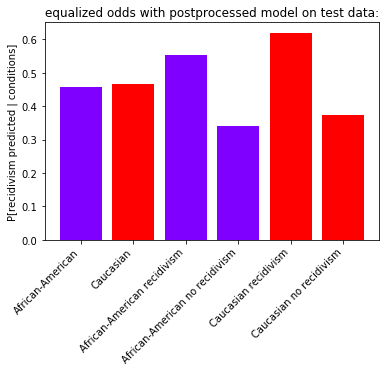

In [6]:
from fairlearn.postprocessing import ThresholdOptimizer
from copy import deepcopy

unconstrained_predictor_wrapper = LogisticRegressionAsRegression(unconstrained_predictor)
postprocessed_predictor_EO = ThresholdOptimizer(
    unconstrained_predictor=unconstrained_predictor_wrapper,
    constraints="equalized_odds")

postprocessed_predictor_EO.fit(X_train, y_train, sensitive_features=sensitive_features_train)

fairness_aware_predictions_EO_train = postprocessed_predictor_EO.predict(X_train, sensitive_features=sensitive_features_train)
fairness_aware_predictions_EO_test = postprocessed_predictor_EO.predict(X_test, sensitive_features=sensitive_features_test)

# show only test data related plot by default - uncomment the next line to see training data plot as well
# show_proportions(X_train, sensitive_features_train, fairness_aware_predictions_EO_train, y_train, description="equalized odds with postprocessed model on training data:", plot_row_index=1)
show_proportions(X_test, sensitive_features_test, fairness_aware_predictions_EO_test, y_test, description="equalized odds with postprocessed model on test data:", plot_row_index=2)
plt.show()


# Post Processing in Detail

While this worked as the numbers show, it's not entirely obvious how it found its solution. The following section will provide a deep dive on post processing for Equalized Odds (EO).

The post processing method (based on work by [Hardt, Price, Srebro](https://arxiv.org/pdf/1610.02413.pdf)) takes a fairness-unaware model and disparity constraints (such as EO) in the constructor and features (X), labels (y), and a sensitive feature (sensitive_features) in the fit method. It subsequently uses the model to make predictions for all samples in X. Note that these predictions could be 0/1 (as in this example), or more categories, or even real valued scores.
In this case, this looks as follows:

In [7]:
scores = unconstrained_predictor_wrapper.predict(X_train)
scores

array([0.08323404, 0.43451484, 0.54980294, ..., 0.56740062, 0.22122327,
       0.37423461])

## Finding threshold rules

The algorithm then tries to find all thresholding rules with which it could divide the data. Any score for which the thresholding rule evaluates to true is predicted to be 1. It does that for each group, so in this case for each race. Depending on the unconstrained predictor's scores you could have lots of thresholding rules, between each set of such values. For each rule we just evaluate the following two probabilities empirically:

$$
P[\hat{Y} = 1 | Y = 0] \text{ which is labeled x below to indicate that it'll be plotted on the x-axis}\\
P[\hat{Y} = 1 | Y = 1] \text{ which is labeled y below to indicate that it'll be plotted on the y-axis}
$$

The former is the false negative rate (of that group), while the latter is the true positive rate (of that group). In this example, the threshold rules would be the ones shown below:

In [8]:
from fairlearn.postprocessing._threshold_optimizer import _reformat_and_group_data
data_grouped_by_sensitive_feature = _reformat_and_group_data(sensitive_features_train, y_train, scores)
data_grouped_by_sensitive_feature.describe()

score                                                    \
                    count      mean       std       min       25%       50%   
sensitive_feature                                                             
African-American   2147.0  0.509660  0.173325  0.035361  0.379570  0.507907   
Caucasian          1389.0  0.400387  0.164785  0.004425  0.273927  0.379796   

                                        label                                \
                        75%       max   count      mean       std  min  25%   
sensitive_feature                                                             
African-American   0.608433  0.989919  2147.0  0.512343  0.499964  0.0  0.0   
Caucasian          0.512370  0.995314  1389.0  0.396688  0.489386  0.0  0.0   

                                  
                   50%  75%  max  
sensitive_feature                 
African-American   1.0  1.0  1.0  
Caucasian          0.0  1.0  1.0

In [10]:
from fairlearn.postprocessing._roc_curve_utilities import _calculate_roc_points

roc_points = {}
for group_name, group in data_grouped_by_sensitive_feature:
    roc_points[group_name] = _calculate_roc_points(data_grouped_by_sensitive_feature.get_group(group_name), 0)
print("Thresholding rules:")
roc_points

     sensitive_feature     score  label
0     African-American  0.083234    1.0
3     African-American  0.551394    1.0
5     African-American  0.458654    1.0
6     African-American  0.346701    1.0
7     African-American  0.263461    0.0
...                ...       ...    ...
3531  African-American  0.452187    0.0
3532  African-American  0.950048    1.0
3533  African-American  0.567401    1.0
3534  African-American  0.221223    0.0
3535  African-American  0.374235    0.0

[2147 rows x 3 columns]


TypeError: list indices must be integers or slices, not float

The base points with (x,y) as (0,0) and (1,1) always exist, because that essentially just means that we're predicting everything as 0 or everything as 1 regardless of the scores from the fairness-unaware model. Let's look at both cases:
- x=0, y=0, threshold rule ">inf": more than infinity is impossible, which means every sample is predicted as 0. That means $P[\hat{Y} = 1 | Y = 0] = 0$ (represented as x) because the predictions $\hat{Y}$ are never 1, and similarly $P[\hat{Y} = 1 | Y = 1] = 0$ (represented as y).
- x=1, y=1, threshold rule ">-inf": more than infinity is always true, which means every sample is predicted as 1. That means $P[\hat{Y} = 1 | Y = 0] = 1$ (represented as x) because the predictions $\hat{Y}$ are always 1, and similarly $P[\hat{Y} = 1 | Y = 1] = 1$ (represented as y).

The more interesting logic happens in between. The x and y values were calculated as follows:

In [ ]:
n_group_0 = {}
n_group_1 = {}
for group_name, group in data_grouped_by_sensitive_feature:
    print("{}:".format(group_name))
    n_group_1[group_name] = sum(group["label"])
    n_group_0[group_name] = len(group) - n_group_1[group_name]
    
    print("    number of samples with label 1: {}".format(n_group_1[group_name]))
    print("    number of samples with label 0: {}".format(n_group_0[group_name]))

In [ ]:
threshold = 0.5
for group_name, group in data_grouped_by_sensitive_feature:
    x_group_0_5 = sum((group["score"] > threshold) & (group["label"] == 0)) / n_group_0[group_name]
    y_group_0_5 = sum((group["score"] > threshold) & (group["label"] == 1)) / n_group_1[group_name]
    print("{}:".format(group_name))
    print("    P[Ŷ = 1 | Y = 0] = {}".format(x_group_0_5))
    print("    P[Ŷ = 1 | Y = 1] = {}".format(y_group_0_5))

Note that it never makes sense to have $x>y$ because in that case you're better off flipping labels, i.e. completely turning around the meaning of the scores. The method automatically does that unless specified otherwise.

## Interpolated Predictions and Probabilistic Classifiers

This way you end up with a set of points above the diagonal line connecting (0,0) and (1,1). We calculate the convex hull based on that, because we can reach any point in between two known thresholding points by interpolation. An interpolation could be $p_0 (x_0, y_0) + p_1 (x_1, y_1)$. For the post processing algorithm that would mean that we use the rule defined by $(x_0, y_0, \text{operation}_0)$ $\quad p_0$ percent of the time, and the rule defined by $(x_1, y_1, \text{operation}_1)$ $\quad p_1$ percent of the time, thus resulting in a probabilistic classifier. Depending on the data certain fairness objectives can only be accomplished with probabilistic classifiers. However, not every use case lends itself to probabilistic classifiers, since it could mean that two people with identical features are classified differently.

## Finding the Equalized Odds solution

From all the ROC points (see below) we need to extract the convex hull for both groups/curves.

In [ ]:
import matplotlib.pyplot as plt

for group_name, group in data_grouped_by_sensitive_feature:
    plt.plot(roc_points[group_name].x, roc_points[group_name].y)
plt.xlabel("$P\ [\ \\hat{Y}=1\ |\ Y=0\ ]$")
plt.ylabel("$P\ [\ \\hat{Y}=1\ |\ Y=1\ ]$")
plt.show()

In the Equalized Odds case, we need to find a point where the presented probabilities (false positive rate, true positive rate, and thereby also true negative rate and false negative rate) for the corresponding groups match while minimizing the error, which is equivalent to finding the minimum error overlap of the convex hulls of the ROC curves. The error in the chart is smallest in the top left corner. This is done as part of the `fit` step above, and we'll repeat it here for completeness. The yellow area is the overlap between the areas under the curve that are reachable with interpolation for both groups. Of course, this works for more than two groups as well. The result is that we have interpolated solutions for each group, i.e. every prediction is calculated as the weighted result of two threshold rules.

In this particular case the Caucasian curve is always below or matching the African-American curve. That means that the area under the Caucasian curve is also identical to the overlap. That does not always happen, though, and overlaps can be fairly complex with multiple intersecting curves defining its outline.

We can actually even look up the specific interpolations and interpret the results. Keep in mind that these interpolations come up with a floating point number between 0 and 1, and represent the probability of getting 0 or 1 in the predicted outcome.

The result for African-Americans is a combination of two thresholding rules. The first rule checks whether the score is above 0.542, the other whether it is above 0.508. The first rule has a weight of 0.19, which means it determines 19% of the resulting probability. The second rule determines the remaining 81%. In the chart the Caucasian curve is below the African-American curve at the EO solution. This means that there is a slight adjustment according to the formula presented below.

The Caucasian rules have somewhat lower thresholds: The first rule's threshold is >0.421 and it is basically the deciding factor with a weight of 99.3%, while the second rule's threshold is >0.404.

Overall, this means that the postprocessing algorithm learned to get probabilities consistent with Equalized Odds and minimal error by setting lower thresholds for Caucasians than for African-Americans. The resulting probability from the formula below is then the probability to get label 1 from the probabilistic classifier.

Note that this does not necessarily mean it's fair. It simply enforced the constraints we asked it to enforce, as described by Equalized Odds. The societal context plays a crucial role in determining whether this is fair.

The parameters `p_ignore` and `prediction_constant` are irrelevant for cases where the curves intersect in the minimum error point. When that doesn't happen, and the minimum error point is only part of one curve, then the interpolation is adjusted as follows
```
p_ignore * prediction_constant + (1 - p_ignore) * (p0 * operation0(score) + p1 * operation1(score))
```
The adjustment should happen to the higher one of the curves and essentially brings it closer to the diagonal as represented by `prediction_constant`. In this case this is not required since the curves intersect, but we are actually slightly inaccurate because we only determine the minimum error point on a grid of x values, instead of calculating the intersection point analytically. By choosing a large `grid_size` this can be alleviated.

In [ ]:
postprocessed_predictor_EO._plot = True
postprocessed_predictor_EO.fit(X_train, y_train, sensitive_features=sensitive_features_train)

for group, interpolation in postprocessed_predictor_EO._post_processed_predictor_by_sensitive_feature.items():
    print("{}:".format(group))
    print("\n ".join(interpolation.__repr__().split(',')))
    print("-----------------------------------")